In [32]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("qianlanzz/xbd-dataset")

print("Path to dataset files:", path)

c:\Users\shiva\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\shiva\.cache\kagglehub\datasets\qianlanzz\xbd-dataset\versions\1


In [33]:
pip install kagglehub

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import glob

In [36]:
dataset_path = "tier1"
images_path = os.path.join(dataset_path, "images")
masks_path  = os.path.join(dataset_path, "masks")


In [37]:
import glob

pre_images  = sorted(glob.glob(os.path.join(images_path, "*_pre_disaster.png")))
post_images = sorted(glob.glob(os.path.join(images_path, "*_post_disaster.png")))

pre_masks   = sorted(glob.glob(os.path.join(masks_path, "*_pre_disaster.png")))
post_masks  = sorted(glob.glob(os.path.join(masks_path, "*_post_disaster.png")))


In [38]:
class XBDDataset(Dataset):
    def __init__(self, pre_images, pre_masks, post_images, post_masks, transform=None):
        self.pre_images = pre_images
        self.pre_masks  = pre_masks
        self.post_images = post_images
        self.post_masks  = post_masks
        self.transform = transform

    def __len__(self):
        return len(self.pre_images)

    def __getitem__(self, idx):
        # load images
        pre_img  = Image.open(self.pre_images[idx]).convert("RGB")
        post_img = Image.open(self.post_images[idx]).convert("RGB")

        # load masks (grayscale)
        pre_mask  = Image.open(self.pre_masks[idx]).convert("L")
        post_mask = Image.open(self.post_masks[idx]).convert("L")

        # apply transforms
        if self.transform:
            pre_img  = self.transform(pre_img)
            post_img = self.transform(post_img)
            pre_mask = self.transform(pre_mask)
            post_mask = self.transform(post_mask)

        return pre_img, pre_mask, post_img, post_mask


In [39]:
dataset = XBDDataset(pre_images, pre_masks, post_images, post_masks, transform)
loader = DataLoader(dataset, batch_size=1, shuffle=True)


In [40]:
pre, pre_mask, post, post_mask = next(iter(loader))

print(pre.shape)
print(pre_mask.shape)
print(post.shape)
print(post_mask.shape)


torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", device)


DEVICE: cpu


In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time


In [43]:
import torch
import torch.nn as nn
from collections import OrderedDict

class SiamUnet(nn.Module):

    def __init__(self, in_channels=3, out_channels_s=2, out_channels_c=5, init_features=16):
        super(SiamUnet, self).__init__()

        features = init_features

        # UNet encoder
        self.encoder1 = SiamUnet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = SiamUnet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = SiamUnet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = SiamUnet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = SiamUnet._block(features * 8, features * 16, name="bottleneck")

        # UNet decoder
        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = SiamUnet._block(features * 16, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = SiamUnet._block(features * 8, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = SiamUnet._block(features * 4, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = SiamUnet._block(features * 2, features, name="dec1")

        self.conv_s = nn.Conv2d(features, out_channels_s, kernel_size=1)

        # Siamese damage head
        self.upconv4_c = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.conv4_c = SiamUnet._block(features * 16, features * 16, name="conv4")
        self.upconv3_c = nn.ConvTranspose2d(features * 16, features * 4, kernel_size=2, stride=2)
        self.conv3_c = SiamUnet._block(features * 8, features * 8, name="conv3")
        self.upconv2_c = nn.ConvTranspose2d(features * 8, features * 2, kernel_size=2, stride=2)
        self.conv2_c = SiamUnet._block(features * 4, features * 4, name="conv2")
        self.upconv1_c = nn.ConvTranspose2d(features * 4, features, kernel_size=2, stride=2)
        self.conv1_c = SiamUnet._block(features * 2, features * 2, name="conv1")

        self.conv_c = nn.Conv2d(features * 2, out_channels_c, kernel_size=1)

    def forward(self, x1, x2):
        # encoder 1
        enc1_1 = self.encoder1(x1)
        enc2_1 = self.encoder2(self.pool1(enc1_1))
        enc3_1 = self.encoder3(self.pool2(enc2_1))
        enc4_1 = self.encoder4(self.pool3(enc3_1))
        bottleneck_1 = self.bottleneck(self.pool4(enc4_1))

        # decoder 1 (pre)
        dec4_1 = self.upconv4(bottleneck_1)
        dec4_1 = self.decoder4(torch.cat((dec4_1, enc4_1), dim=1))
        dec3_1 = self.upconv3(dec4_1)
        dec3_1 = self.decoder3(torch.cat((dec3_1, enc3_1), dim=1))
        dec2_1 = self.upconv2(dec3_1)
        dec2_1 = self.decoder2(torch.cat((dec2_1, enc2_1), dim=1))
        dec1_1 = self.upconv1(dec2_1)
        dec1_1 = self.decoder1(torch.cat((dec1_1, enc1_1), dim=1))
        out_pre = self.conv_s(dec1_1)

        # encoder 2
        enc1_2 = self.encoder1(x2)
        enc2_2 = self.encoder2(self.pool1(enc1_2))
        enc3_2 = self.encoder3(self.pool2(enc2_2))
        enc4_2 = self.encoder4(self.pool3(enc3_2))
        bottleneck_2 = self.bottleneck(self.pool4(enc4_2))

        # decoder 2 (post)
        dec4_2 = self.upconv4(bottleneck_2)
        dec4_2 = self.decoder4(torch.cat((dec4_2, enc4_2), dim=1))
        dec3_2 = self.upconv3(dec4_2)
        dec3_2 = self.decoder3(torch.cat((dec3_2, enc3_2), dim=1))
        dec2_2 = self.upconv2(dec3_2)
        dec2_2 = self.decoder2(torch.cat((dec2_2, enc2_2), dim=1))
        dec1_2 = self.upconv1(dec2_2)
        dec1_2 = self.decoder1(torch.cat((dec1_2, enc1_2), dim=1))
        out_post = self.conv_s(dec1_2)

        # Siamese difference
        diff = bottleneck_2 - bottleneck_1

        dec4_c = self.upconv4_c(diff)
        dec4_c = self.conv4_c(torch.cat((dec4_c, enc4_2 - enc4_1), dim=1))

        dec3_c = self.upconv3_c(dec4_c)
        dec3_c = self.conv3_c(torch.cat((dec3_c, enc3_2 - enc3_1), dim=1))

        dec2_c = self.upconv2_c(dec3_c)
        dec2_c = self.conv2_c(torch.cat((dec2_c, enc2_2 - enc2_1), dim=1))

        dec1_c = self.upconv1_c(dec2_c)
        dec1_c = self.conv1_c(torch.cat((dec1_c, enc1_2 - enc1_1), dim=1))

        out_cls = self.conv_c(dec1_c)

        return out_pre, out_post, out_cls

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(OrderedDict([
            (name + "_conv1", nn.Conv2d(in_channels, features, 3, padding=1, bias=False)),
            (name + "_bn1", nn.BatchNorm2d(features)),
            (name + "_relu1", nn.ReLU(inplace=True)),
            (name + "_conv2", nn.Conv2d(features, features, 3, padding=1, bias=False)),
            (name + "_bn2", nn.BatchNorm2d(features)),
            (name + "_relu2", nn.ReLU(inplace=True)),
        ]))


In [44]:
model = SiamUnet().to(device)


In [45]:
len(pre_images), len(post_images), len(pre_masks), len(post_masks)


(2799, 2799, 2799, 2799)

In [49]:
model = SiamUnet()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [50]:
num_epochs = 1

for epoch in range(num_epochs):
    print(f"\nStart of epoch {epoch}")
    total_loss = 0

    for step, (pre_img, pre_mask, post_img, post_mask) in enumerate(loader):

        pre_img  = pre_img.to(device)
        post_img = post_img.to(device)

        pre_mask  = pre_mask.to(device)
        post_mask = post_mask.to(device)

        pre_mask_oh  = mask_to_onehot(pre_mask)
        post_mask_oh = mask_to_onehot(post_mask)

        out_pre, out_post, _ = model(pre_img, post_img)

        loss_pre  = criterion(out_pre, pre_mask_oh)
        loss_post = criterion(out_post, post_mask_oh)

        loss = loss_pre + loss_post

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if (step+1) % 100 == 0:
            print(f"Step {step+1} | Loss: {loss.item():.4f}")

    print(f"Epoch {epoch} completed. Avg Loss = {total_loss/len(loader):.4f}")



Start of epoch 0
Step 100 | Loss: 0.7868
Step 200 | Loss: 0.6452
Step 300 | Loss: 0.2825
Step 400 | Loss: 0.1506
Step 500 | Loss: 0.1244
Step 600 | Loss: 0.1801
Step 700 | Loss: 0.3213
Step 800 | Loss: 0.9223
Step 900 | Loss: 0.1347
Step 1000 | Loss: 0.0633
Step 1100 | Loss: 0.0668
Step 1200 | Loss: 0.2470
Step 1300 | Loss: 0.1943
Step 1400 | Loss: 0.0949
Step 1500 | Loss: 0.0921
Step 1600 | Loss: 0.0800
Step 1700 | Loss: 0.0596
Step 1800 | Loss: 0.1333
Step 1900 | Loss: 0.1023
Step 2000 | Loss: 0.0727
Step 2100 | Loss: 0.0841
Step 2200 | Loss: 0.0388
Step 2300 | Loss: 0.0283
Step 2400 | Loss: 0.8200
Step 2500 | Loss: 0.3031
Step 2600 | Loss: 0.0583
Step 2700 | Loss: 0.6715
Epoch 0 completed. Avg Loss = 0.2773


In [51]:
torch.save(model, "siamunet_model.pth")


In [52]:
dataset_path = "test"
images_path = os.path.join(dataset_path, "images")
masks_path  = os.path.join(dataset_path, "masks")


In [53]:
import glob

test_pre_images  = sorted(glob.glob(os.path.join(images_path, "*_pre_disaster.png")))
test_post_images = sorted(glob.glob(os.path.join(images_path, "*_post_disaster.png")))

test_pre_masks   = sorted(glob.glob(os.path.join(masks_path, "*_pre_disaster.png")))
test_post_masks  = sorted(glob.glob(os.path.join(masks_path, "*_post_disaster.png")))

In [57]:
class XBDDataset1(Dataset):
    def __init__(self, pre_images, pre_masks, post_images, post_masks,
                 img_transform=None, mask_transform=None):

        self.pre_images = pre_images
        self.pre_masks = pre_masks
        self.post_images = post_images
        self.post_masks = post_masks

        self.img_transform = img_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.pre_images)

    def __getitem__(self, idx):

        # Load images
        pre_img = Image.open(self.pre_images[idx]).convert("RGB")
        post_img = Image.open(self.post_images[idx]).convert("RGB")

        # Load masks
        pre_mask = Image.open(self.pre_masks[idx])
        post_mask = Image.open(self.post_masks[idx])

        # Apply image transform
        if self.img_transform:
            pre_img = self.img_transform(pre_img)
            post_img = self.img_transform(post_img)

        # Apply mask transform (NEAREST)
        if self.mask_transform:
            pre_mask = self.mask_transform(pre_mask)
            post_mask = self.mask_transform(post_mask)

        # Ensure masks are integer labels
        pre_mask = pre_mask.long().squeeze(0)
        post_mask = post_mask.long().squeeze(0)

        return pre_img, pre_mask, post_img, post_mask




In [58]:

test_dataset = XBDDataset1(
    test_pre_images,
    test_pre_masks,
    test_post_images,
    test_post_masks,
    img_transform=test_img_transform,
    mask_transform=test_mask_transform
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


SyntaxError: invalid syntax (143930088.py, line 1)

In [66]:
pip install scikit-learn


   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ------- -------------------------------- 1.6/8.7 MB 9.6 MB/s eta 0:00:01
   -------------------- ------------------- 4.5/8.7 MB 12.0 MB/s eta 0:00:01
   --------------------------------- ------ 7.3/8.7 MB 12.6 MB/s eta 0:00:01
   ---------------------------------------- 8.7/8.7 MB 12.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   -- ------------------------------------- 2.6/38.5 MB 13.9 MB/s eta 0:00:03
   ----- ---------------------------------- 5.0/38.5 MB 12.3 MB/s eta 0:00:03
   -------- ------------------------------- 7.9/38.5 MB 12.8 MB/s eta 0:00:03
   ---------- ----------------------------- 10.5/38.5 MB 12.9 MB/s eta 0:00:03
   ------------- -------------------------- 13.4/38.5 MB 13.0 MB/s eta 0:00:02
   ---------------- ----------------------- 16.3/38.5 MB 13.0 MB/s eta 0:00:02
   ------------------- -------------------- 18.9/38.5 MB 13.2 MB/s eta 0:00:02
   -


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [70]:
from sklearn.metrics import confusion_matrix

import numpy as np

In [71]:
num_classes = 5
conf_mat = np.zeros((num_classes, num_classes), dtype=np.int64)


In [72]:
model.eval()

with torch.no_grad():
    for pre_img, pre_mask, post_img, post_mask in test_loader:

        pre_img = pre_img.to(device)
        post_img = post_img.to(device)
        post_mask = post_mask.to(device)

        # Get predictions from model
        _, _, out_damage = model(pre_img, post_img)

        # Predictions (n, 256, 256)
        preds = torch.argmax(out_damage, dim=1)

        # Flatten tensors
        y_true = post_mask.cpu().numpy().flatten()
        y_pred = preds.cpu().numpy().flatten()

        # Update confusion matrix
        cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
        conf_mat += cm


In [76]:
pip install seaborn

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ----------- ---------------------------- 2.4/8.1 MB 11.8 MB/s eta 0:00:01
   --------------------- ------------------ 4.5/8.1 MB 11.5 MB/s eta 0:00:01
   ------------------------------------ --- 7.3/8.1 MB 12.3 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 12.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------- ----------------------------- 2.9/11.0 MB 15.1 MB/s eta 0:00:01
   ---------------------- ----------------- 6.3/11.0 MB 16.2 MB/s eta 0:00:01
   ------------------------------------- -- 10.2/11.0 MB 16.9 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 16.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 17.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


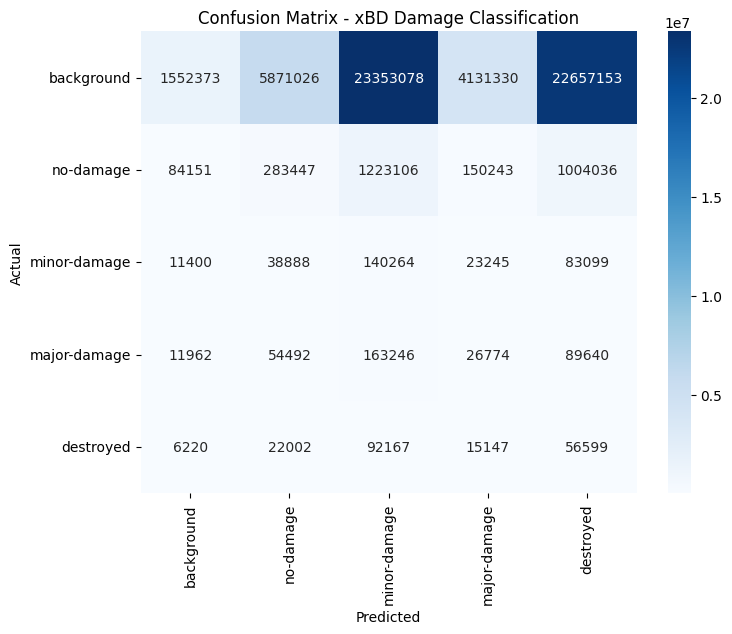

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

class_names = [
    "background",
    "no-damage",
    "minor-damage",
    "major-damage",
    "destroyed"
]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - xBD Damage Classification")
plt.show()


In [81]:
test_pre_img, test_pre_mask, test_post_img, test_post_mask = next(iter(test_loader))

# Run model
with torch.no_grad():
    outputs = model(test_pre_img, test_post_img)

softmax = torch.nn.Softmax(dim=1)
preds_cls = torch.argmax(softmax(outputs[2]), dim=1)


In [156]:
import numpy as np

xBD_COLORS = np.array([
    [167, 216, 240],   # 0 - No Damage (soft sky blue)
    [124, 166, 249],   # 1 - Minor Damage (lavender blue)
    [93, 63, 211],     # 2 - Major Damage (indigo purple)
    [231, 84, 128],    # 3 - Destroyed (fuchsia pink)
    [198, 32, 72],     # 4 - Unclassified (rose red)
], dtype=np.uint8)

LABEL_NAMES = [
    "no-damage",
    "minor-damage",
    "major-damage",
    "destroyed",
    "unclassified",
]


In [109]:
def mask_to_rgb(mask):
    """mask: (H, W) values 0–5 → returns (H, W, 3) RGB"""
    return xBD_COLORS[mask]


In [110]:
preds_cls = torch.argmax(outputs[2], dim=1)   # shape (1, H, W)


In [158]:
pred_mask = preds_cls[0].cpu().numpy()   # (H, W)
pred_rgb = mask_to_rgb(pred_mask)        # (H, W, 3)


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

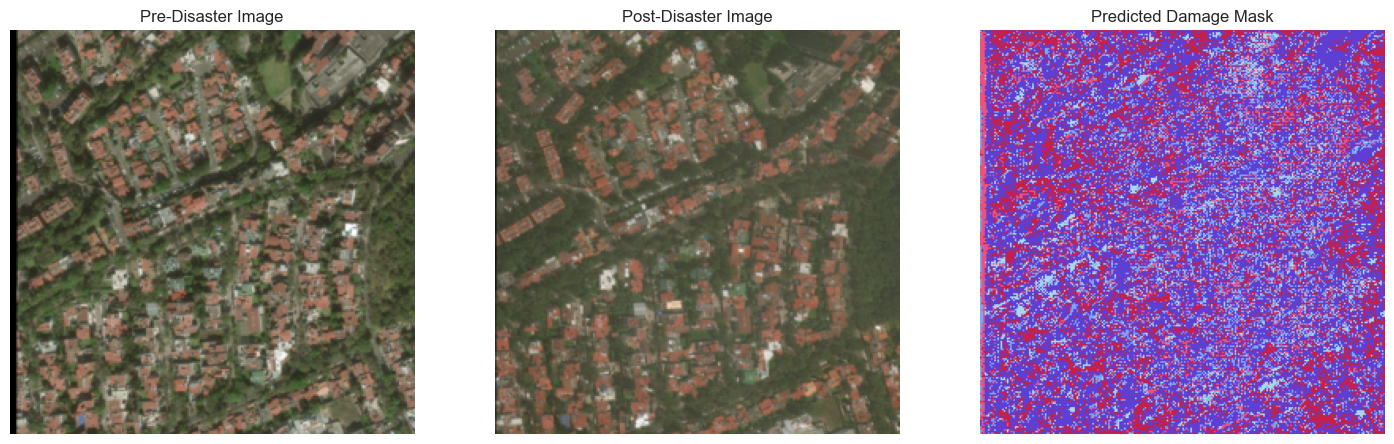

In [159]:
import matplotlib.pyplot as plt

# assuming you already ran:
# pre_img, post_img, and preds_cls

# convert tensors to numpy
pre_np = pre_img[0].permute(1,2,0).cpu().numpy()
post_np = post_img[0].permute(1,2,0).cpu().numpy()

# prediction mask → numpy
pred_mask = preds_cls[0].cpu().numpy()
pred_rgb = mask_to_rgb(pred_mask)

# create plot
plt.figure(figsize=(24,10))

# PRE-DISASTER
plt.subplot(1,4,1)
plt.title("Pre-Disaster Image")
plt.imshow(pre_np)
plt.axis("off")

# POST-DISASTER
plt.subplot(1,4,2)
plt.title("Post-Disaster Image")
plt.imshow(post_np)
plt.axis("off")

# PRED MASK
plt.subplot(1,4,3)
plt.title("Predicted Damage Mask")
plt.imshow(pred_rgb)
plt.axis("off")

# LEGEND



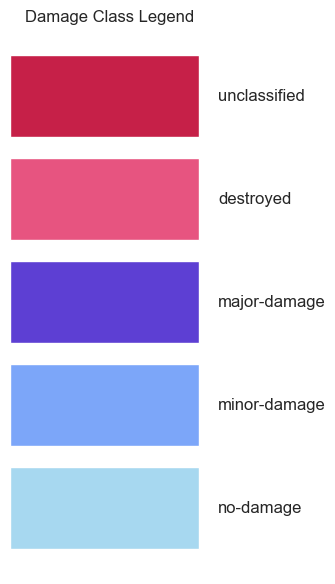

In [149]:
plt.subplot(1,4,4)
plt.title("Damage Class Legend")

for i, name in enumerate(LABEL_NAMES):
    plt.barh(i, 1, color=xBD_COLORS[i]/255)
    plt.text(1.1, i, name, va='center')

plt.axis("off")

plt.tight_layout()
plt.show()

In [118]:
DISASTER_REGION_MAP = {
    "mexico-earthquake": "Mexico",
    "california-wildfire": "California, USA",
    "socal-fire": "California, USA",
    "hurricane-michael": "Florida, USA",
    "hurricane-florence": "North Carolina, USA",
    "midwest-flooding": "USA (Nebraska/Iowa)",
    "puerto-rico-earthquake": "Puerto Rico",
    "palu-tsunami": "Indonesia",
    "china-earthquake": "China",
    "haiti-earthquake": "Haiti",
    "philippines-typhoon": "Philippines",
    "tornadoes": "USA",
    "mozambique-cyclone": "Mozambique",
    "nepal-flooding": "Nepal",
    "japan-typhoon": "Japan",
    "guatemala-volcano": "Guatemala",
    "india-flooding": "India",
    "australia-bushfire": "Australia",
    "venezuela-landslide": "Venezuela"
}


In [119]:
def search_by_region(region_name):
    region_name = region_name.lower()

    matches = [
        disaster for disaster, region in DISASTER_REGION_MAP.items()
        if region_name in region.lower()
    ]

    if not matches:
        print("No matching region found.")
        return []

    return matches


In [120]:
import glob

def get_files_for_disaster(disaster, img_folder="tier1/images"):
    pre_files = sorted(glob.glob(f"{img_folder}/{disaster}*_pre_disaster.png"))
    post_files = sorted(glob.glob(f"{img_folder}/{disaster}*_post_disaster.png"))
    return pre_files, post_files


In [121]:
import re

def extract_id(filepath):
    # finds 8 digit number
    match = re.search(r"_(\d{8})_", filepath)
    return match.group(1) if match else None


In [ ]:
region = input("Enter region/country name: ")

# Step 1 — find disasters in the region
matched_disasters = search_by_region(region)

if not matched_disasters:
    raise SystemExit()

print("\nDisasters found:")
for i, d in enumerate(matched_disasters, 1):
    print(f"{i}. {d} ({DISASTER_REGION_MAP[d]})")

# Step 2 — user picks disaster
choice = int(input("\nSelect a disaster (number): "))
selected_disaster = matched_disasters[choice - 1]

print("\nYou chose:", selected_disaster)

# Step 3 — list available image IDs
pre_files, post_files = get_files_for_disaster(selected_disaster)

ids = [extract_id(f) for f in pre_files]

print("\nAvailable Image IDs:")
for idx in ids:
    print(idx)

# Step 4 — user picks an ID
selected_id = input("\nEnter an image ID from the list above: ")

# Step 5 — Find matching pre/post
pre_path = [f for f in pre_files if selected_id in f][0]
post_path = [f for f in post_files if selected_id in f][0]

print("\nLoading:")
print("Pre:", pre_path)
print("Post:", post_path)

# Step 6 — Load and display




Disasters found:
1. mexico-earthquake (Mexico)

You chose: mexico-earthquake

Available Image IDs:
00000000
00000001
00000002
00000003
00000004
00000007
00000008
00000009
00000011
00000013
00000015
00000017
00000018
00000019
00000020
00000021
00000023
00000024
00000027
00000029
00000030
00000031
00000032
00000033
00000034
00000035
00000037
00000039
00000040
00000041
00000042
00000043
00000044
00000046
00000047
00000048
00000049
00000052
00000053
00000055
00000057
00000059
00000064
00000066
00000067
00000068
00000070
00000072
00000074
00000075
00000078
00000079
00000082
00000083
00000084
00000085
00000086
00000087
00000088
00000089
00000092
00000093
00000096
00000098
00000100
00000101
00000102
00000103
00000104
00000105
00000107
00000108
00000110
00000111
00000112
00000114
00000115
00000118
00000119
00000120
00000122
00000125
00000126
00000127
00000128
00000129
00000132
00000136
00000138
00000140
00000141
00000142
00000143
00000144
00000146
00000148
00000150
00000151
00000152
00000153


In [130]:
from PIL import Image
import torch

# Load + transform
pre_img_raw = Image.open(pre_path).convert("RGB")
post_img_raw = Image.open(post_path).convert("RGB")

pre_img = test_img_transform(pre_img_raw).unsqueeze(0)
post_img = test_img_transform(post_img_raw).unsqueeze(0)

# Run model
with torch.no_grad():
    outputs = model(pre_img, post_img)

preds_cls = torch.argmax(outputs[2], dim=1)
pred_mask = preds_cls[0].cpu().numpy()

pred_rgb = mask_to_rgb(pred_mask)


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

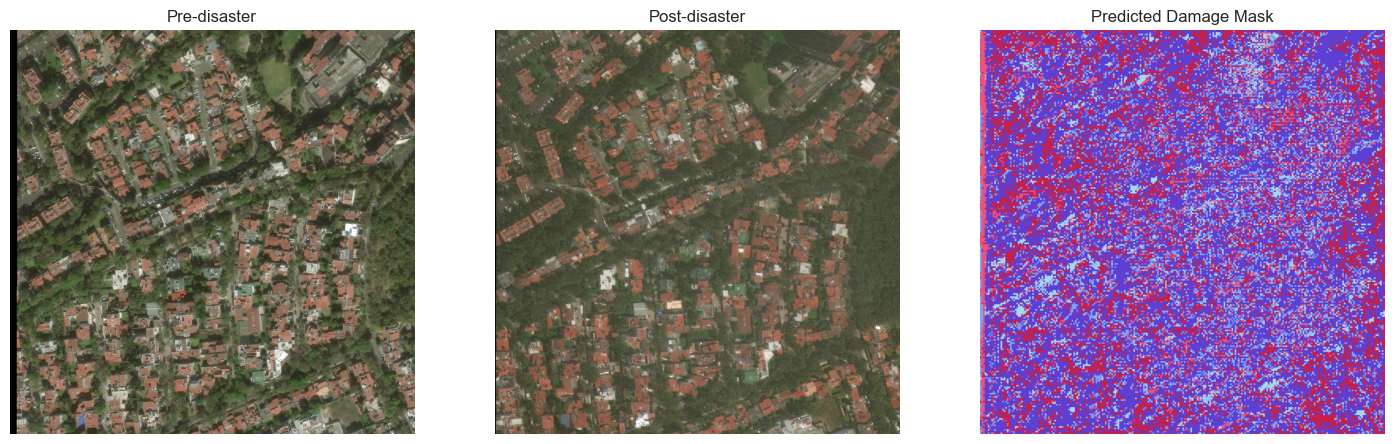

In [153]:
import matplotlib.pyplot as plt

pre_np = pre_img_raw
post_np = post_img_raw

plt.figure(figsize=(24,10))

# Pre
plt.subplot(1,4,1)
plt.title("Pre-disaster")
plt.imshow(pre_np)
plt.axis("off")

# Post
plt.subplot(1,4,2)
plt.title("Post-disaster")
plt.imshow(post_np)
plt.axis("off")

# Prediction
plt.subplot(1,4,3)
plt.title("Predicted Damage Mask")
plt.imshow(pred_rgb)
plt.axis("off")



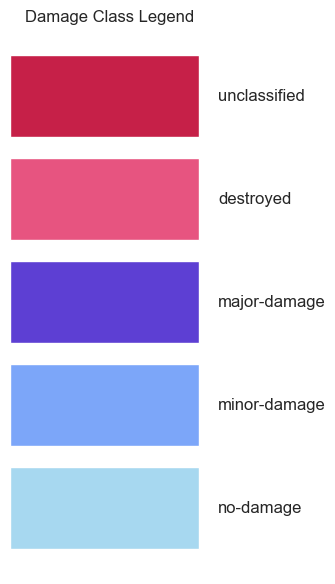

In [152]:

# Legend
plt.subplot(1,4,4)
plt.title("Damage Class Legend")

for i, name in enumerate(LABEL_NAMES):
    plt.barh(i, 1, color=xBD_COLORS[i]/255)
    plt.text(1.1, i, name, va="center")

plt.axis("off")

plt.tight_layout()
plt.show()

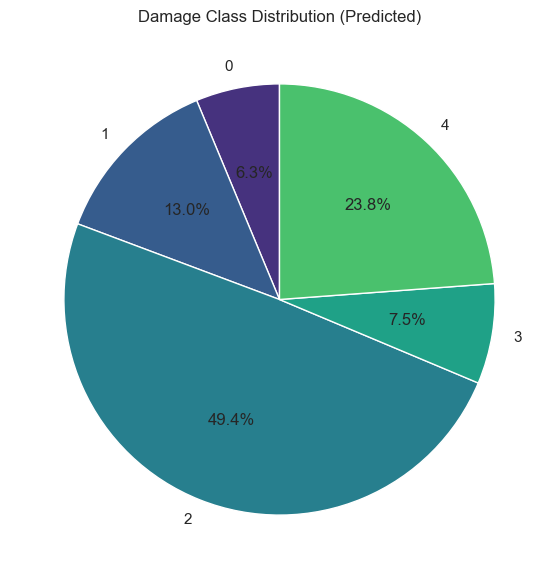

In [143]:
import numpy as np
import matplotlib.pyplot as plt

classes, counts = np.unique(pred_mask, return_counts=True)

plt.figure(figsize=(7,7))
plt.title("Damage Class Distribution (Predicted)")
plt.pie(counts, labels=classes, autopct="%1.1f%%", startangle=90)
plt.show()
